# Lamp Powers via Least Squares

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>A set of $n$ lamps illuminates an area that we divide into $m$ regions (pixels). We let $l_{i}$ denote the lighting level in region $i$, so the $m$-vector $l$ gives the illumination levels across all regions. We let $p_{i}$ denote the power at which lamp $i$ operates, so the $n$-vector $p$ gives the set of lamp powers. The vector of illumination levels is a linear function of the lamp powers, so we have $l=Ap$ for some $m \times n$ matrix $A$. The $j$th column of $A$ gives the illumination pattern for lamp $j$, i.e., the illumination when lamp $j$ has power $1$ and all other lamps are off. We will assume that $A$ has linearly independent columns (and therefore is tall). The $i$th row of $A$ gives the sensitivity of pixel $i$ to the $n$ lamp powers. Your mission is to find lamp powers that result in a desired illumination pattern $l^{des}$, such as $l^{des}=a·1$, ($1$ the vector with all ones) which is uniform illumination with value across the area. In other words, we seek $p$ so that $Ap≈l^{des}$. We can use least squares to find $\hat{p}$ that minimizes the sum square deviation from the desired illumination, $\|Ap-l^{des}\|_{2}^{2}$. As an example use $n=10$ lamps, the area being an $25\times25$ grid with $m=625$ pixels, each $1m^{2}$. The $(x,y)$ positions of lamps and their heigh above floor are:</p>

<p style='text-align: center;'>$\{(4.1, 20.4, 4), (14.1, 21.3, 3.5), (22.6, 17.1, 6), (5.5, 12.3, 4), (12.2, 9.7, 4)\}$</p>
<p style='text-align: center;'>$\{(15.3, 13.8, 6), (21.3, 10.5, 5.5), (3.9, 3.3, 5), (13.1, 4.3, 5), (20.3, 4.2, 4.5)\}$</p>

<p style='text-align: justify;'>The illumination decays with an inverse square law, so $A_{ij}$ proportional to $d^{-2}_{ij}$, where $d_{ij}$ is the $(3-D)$ distance between the center of the pixel and the lamp position. The matrix $A$ is scaled so that when all lamps have power one, the average illumination level is one. The desired illumination pattern is $1$, i.e., uniform with value $1$.</p>

<p style='text-align: justify;'><i>Question 1</i><br>Create two graphs to show the illumination of the two patterns.<br> The first with all lamps set to $1$ and the other that minimize the sum square deviation with a desired uniform illumination.</p>

<p style='text-align: justify;'><i>Question 2</i><br>What are the RMS errors in both cases?</p>

<p style='text-align: justify;'><i>Question 3</i><br>Create the histogram of patch illumination values for all lamp powers one, and for lamp powers found by LS.</p>

> [***Introduction to Applied Linear Algebra:*** *Vectors, Matrices, and Least Squares*](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/lamp_powers_via_least_squares/readings/vectors_matrices_and_least_squares.pdf)  
> *Book by Stephen Boyd and Lieven Vandenberghe*  
> *Cambridge University Press*

## *Table of Contents*

- [*1. Libraries*](#libraries)
- [*2. Case 1: Lamps Have Power 1*](#case_one)
    - [*2.1. Centroids*](#centroids)
    - [*2.2. Matrix A*](#matrix_a)
    - [*2.3. Initial Lamp Powers*](#initial_lamp_powers)
    - [*2.4. Scaled Matrix A*](#scaled_matrix_a)
    - [*2.5. RMSE*](#rmse_one)
    - [*2.6. Illumination Pattern*](#illumination_pattern_one)
- [*3. Case 2: Lamp Powers Found by LS*](#case_two)
    - [*3.1. Lamp Powers Estimates*](#lamp_powers_estimates)
    - [*3.2. RMSE*](#rmse_two)
    - [*3.3. Illumination Pattern*](#illumination_pattern_two)
- [*4. Histograms*](#histograms)

---

## Libraries <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score
from scipy.optimize import nnls 
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Case 1: Lamps Have Power 1 <a class='anchor' id='case_one'></a>

### *Centroids* <a class='anchor' id='centroids'></a>

- First, we need to calculate the coordinates of the center of each pixel
- Since all pixels are on the ground, their heights will be zero
- The area is a $25\times25$ grid with $625$ pixels, each $1m^{2}$
- Thus, the centers will be in the half of the pixels dimensions (e.g. $0.5m\times0.5m$)

##### *Calculate the center of each region (pixel)*

In [2]:
# initialize the dimensions of the area and the pixels
area_length, area_width, pixel_dim = 25, 25, 1

# function to calculate centroids
def calculate_centroids(area_length, area_width, pixel_dim):
    
    # print dimensions
    print(f'The dimensions of the area are {area_length}x{area_width}.')
    print(f'The dimensions of each pixel in the area are {pixel_dim}x{pixel_dim}.', end='\n\n')
    
    # initialize an empty list
    # to store the coordinates of the center of each pixel
    centroids = list()
    
    # loop (horizontally)
    for x in range(area_length):
        
        # append an empty list
        # in which we will store the (x,y,z) coordinates
        centroids.append(list())
        
        # loop (vertically)
        for y in range(area_width):
            
            # append the coordinates of the pixel in loop
            # (length, width, height)
            centroids[x].append((x+pixel_dim/2, y+pixel_dim/2, 0))
    
    # print shape
    print(f'np.shape(centroids): {np.shape(centroids)}')
            
    return centroids

# execute the function
centroids = calculate_centroids(area_length, area_width, pixel_dim)

The dimensions of the area are 25x25.
The dimensions of each pixel in the area are 1x1.

np.shape(centroids): (25, 25, 3)


### *Matrix A* <a class='anchor' id='matrix_a'></a>

- The $j$th column of $A$ gives the illumination pattern for lamp $j$, i.e., the illumination when lamp $j$ has power $1$ and all other lamps are off
- We will assume that $A$ has linearly independent columns (and therefore is tall)
- The $i$th row of $A$ gives the sensitivity of pixel $i$ to the $n$ lamp powers
- Therefore, matrix A will end up with a shape $625 \times 10$
- The illumination decays with an inverse square law, so $A_{ij}$ is proportional to $d^{-2}_{ij}$, the $(3D)$ distance between the center of the pixel and the lamp position

##### *Define the position (x,y) and height (z) of each lamp*

In [3]:
# define the coordinates of each lamp
lamps = [(4.1, 20.4, 4), (14.1, 21.3, 3.5), (22.6, 17.1, 6), (5.5, 12.3, 4), (12.2, 9.7, 4),
         (15.3, 13.8, 6), (21.3, 10.5, 5.5), (3.9, 3.3, 5), (13.1, 4.3, 5), (20.3, 4.2, 4.5)]

##### *Compute matrix A*

In [4]:
# function to compute A matrix
def compute_A_matrix(centroids, lamps):

    # initialize a list
    # to store A
    A = list()
    
    # loop through each row
    for each_row in centroids:
        
        # loop through each pixel of each row
        for each_pixel in each_row:
            
            # initialize a list
            # to store the sensitivy of the pixel in loop from each lamp
            temp = list()
            
            # loop through lamps
            for each_lamp in lamps:
                
                # calculate euclidean distance between pixel and lamp
                # it corresponds to the illumination level of the pixel in loop from the lamp in loop
                distance = math.pow((np.linalg.norm(np.asarray(each_pixel) - np.asarray(each_lamp))),-2)
                temp.append(distance)
                
            A.append(temp)
        
    # preview the shape of A
    print(f'The shape of A is {np.shape(A)}.')
    
    return A

# execute the function
A = compute_A_matrix(centroids, lamps)

The shape of A is (625, 10).


### *Initial Lamp Powers* <a class='anchor' id='initial_lamp_powers'></a>

- We let $p_{i}$ denote the power at which lamp $i$ operates, so the $n$-vector $p$ gives the set of lamp powers
- We let $l_{i}$ denote the lighting level in region $i$, so the $m$-vector $l$ gives the illumination levels across all regions
- The vector of illumination levels is a linear function of the lamp powers, so we have $l=Ap$ for some $m\times{n}$ matrix $A$

##### *Initialize the power of each lamp and calculate the average illumination level*

In [5]:
# initial power of each lamp
# all lamps have power = 1
P_init = np.ones((10,))

# illumination levels of each pixel
# AxP_init = (625x10)x(10,) = (625,)
L = np.dot(A, P_init)

# preview the avg illumination level
# when all lamps have power = 1
print(f'The average illumination level when all lamps have power 1 is {np.mean(L)}.')

The average illumination level when all lamps have power 1 is 0.09596080098089171.


### *Scaled Matrix A* <a class='anchor' id='scaled_matrix_a'></a>

- The matrix $A$ is scaled so that when all lamps have power one, the average illumination level is one.

##### *Scale matrix A so that when all lamps have power 1, the average illumination level is one*

In [6]:
# find the weight needed to scale A
weight = (1 - np.mean(L)) / np.mean(L)
print(f'The weight is {weight}.', end='\n\n')

# create the scaled A
A_scaled = np.asarray(A) + (np.asarray(A) * weight)

# illumination levels of each pixels
# when all lamps have power = 1 and matrix A is scaled
L_scaled = np.dot(A_scaled, P_init)

# preview the avg illumination level
# when all lamps have power = 1 and matrix A is scaled
print(f'The average illumination level when all lamps have power 1 is {np.mean(L_scaled)}.')

The weight is 9.420921769912342.

The average illumination level when all lamps have power 1 is 0.9999999999999998.


### *RMSE* <a class='anchor' id='rmse_one'></a>

##### *Compute the RMSE of the predictions*

In [7]:
# compute RMSE
rmse = np.sqrt(mean_squared_error((np.ones(625,)), np.dot(A_scaled, P_init)))

# preview error
print(f'The RMSE of the predictions is {rmse}.')

The RMSE of the predictions is 0.2417413185380788.


### *Illumination Pattern* <a class='anchor' id='illumination_pattern_one'></a>

##### *Create a graph to show the illumination pattern when all lamps have power 1*

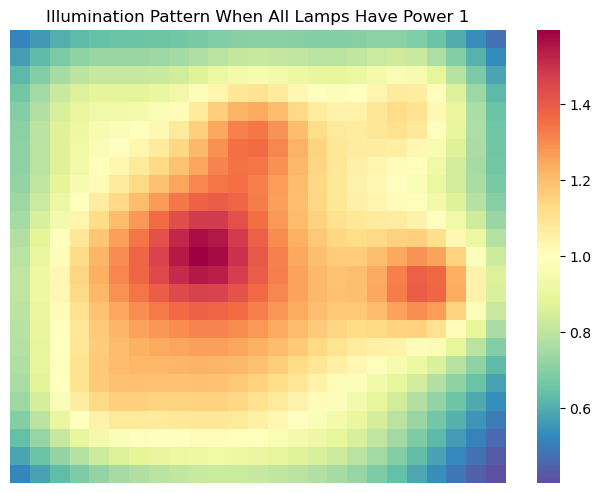

In [8]:
# create ground
ground = np.reshape(L_scaled, (25,25)) 

# plot the illumination pattern heatmap
plt.figure(figsize=(8,6),dpi=100,facecolor='white')
sns.heatmap(ground, cmap='Spectral_r')
plt.xticks([])
plt.yticks([])
plt.title('Illumination Pattern When All Lamps Have Power 1')
plt.savefig('./images/illumination_pattern_lamp_powers_one.svg')
plt.show()

## Case 2: Lamp Powers Found by Least Squares <a class='anchor' id='case_two'></a>

### *Lamp Powers Estimates* <a class='anchor' id='lamp_powers_estimates'></a>

- We need to find lamp powers that result in a desired illumination pattern $l^{des}$, such as $l^{des}=a·1$, ($1$ the vector with all ones)
- The desired illumination pattern is $1$, i.e., uniform with value $1$ across the area
- In other words, we seek $p$ so that $Ap≈l^{des}$
- We can use least squares to find $\hat{p}$ that minimizes the sum square deviation from the desired illumination, $\|Ap-l^{des}\|_{2}^{2}$

##### *Estimate the lamp powers needed to achieve the desired illumination pattern using Least Squares*

In [9]:
# ideally, all regions should have the same illumination level
L_des = np.ones((625,))

# calculate P estimates (estimated power of each lamp)
# based on the non-negative least squares method
P_hat = nnls(A_scaled, L_des)[0]

# preview the estimated power of each lamp
for i in range(10):
    print(f'Lamp 0{i+1}: {P_hat[i]}' if i < 9 else f'Lamp {i+1}: {P_hat[i]}')

Lamp 01: 1.4621101798266405
Lamp 02: 0.787974326213186
Lamp 03: 2.9664104724031883
Lamp 04: 0.7435804226879912
Lamp 05: 0.08317333038945018
Lamp 06: 0.21263944602371737
Lamp 07: 0.21218407925533053
Lamp 08: 2.0511481462520007
Lamp 09: 0.9076031545599353
Lamp 10: 1.4722246425160115


### *RMSE* <a class='anchor' id='rmse_two'></a>

##### *Compute the RMSE of the predictions*

In [10]:
# compute RMSE
rmse_ls = np.sqrt(mean_squared_error((np.ones(625,)), np.dot(A_scaled, P_hat)))

# preview error
print(f'The RMSE of the predictions is {rmse_ls}.')

The RMSE of the predictions is 0.1403904813427606.


### *Illumination Pattern* <a class='anchor' id='illumination_pattern_two'></a>

##### *Create a graph to show the illumination pattern with lamp powers found by LS*

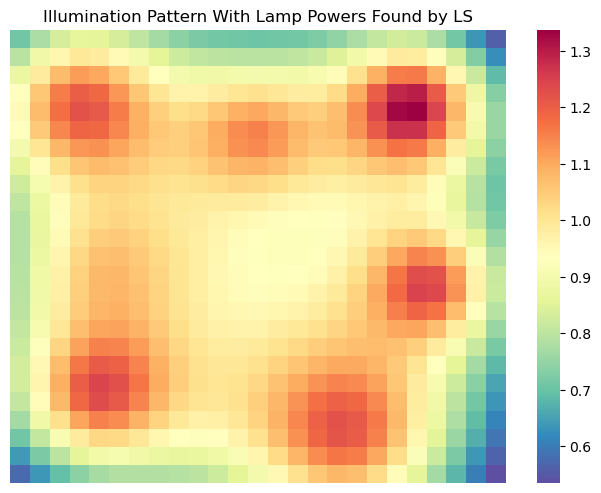

In [11]:
# compute the illumination levels
# using the lamp powers estimated through least squares
L_ls = np.dot(A_scaled, P_hat)

# create ground
ground_ls = np.reshape(L_ls, (25,25))

# plot the illumination pattern heatmap
plt.figure(figsize=(8,6),dpi=100,facecolor='white')
sns.heatmap(ground_ls, cmap='Spectral_r')
plt.xticks([])
plt.yticks([])
plt.title('Illumination Pattern With Lamp Powers Found by LS')
plt.savefig('./images/illumination_pattern_lamp_powers_found_by_ls.svg')
plt.show()

## Histograms <a class='anchor' id='histograms'></a>

##### *Create the histogram of patch illumination values for all lamp powers 1, and for lamp powers found by LS*

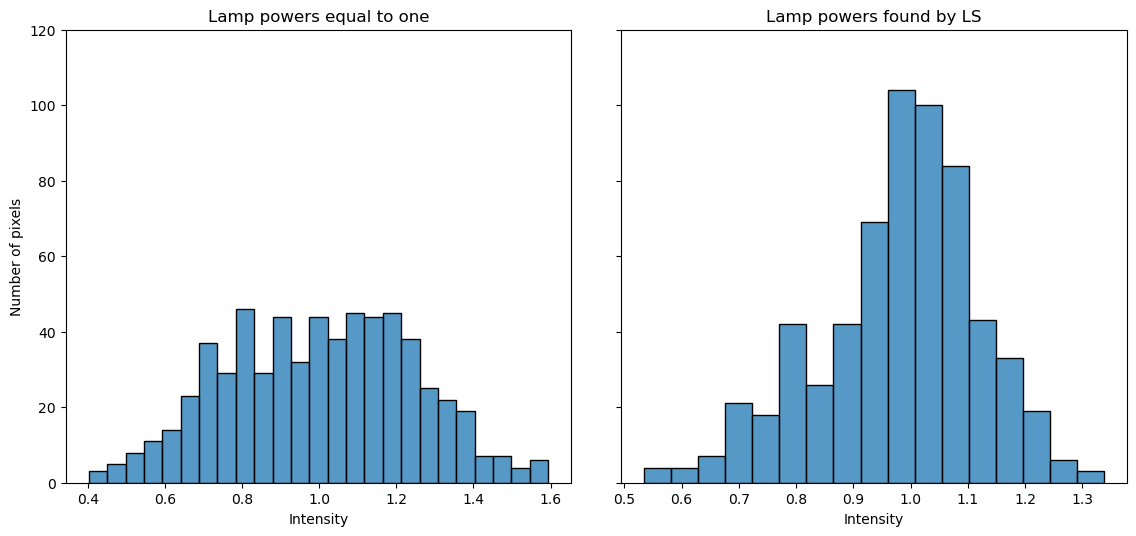

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=100,facecolor='white',sharey=True)
# plot for lamp powers 1
sns.histplot(L_scaled, bins=25, ax=ax[0])
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Number of pixels')
ax[0].set_ylim(0,120)
ax[0].set_title('Lamp powers equal to one')
# plot for lamp powers found by LS
sns.histplot(L_ls, bins=17, ax=ax[1])
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Number of pixels')
ax[1].set_title('Lamp powers found by LS')
plt.tight_layout(pad=3)
plt.savefig('./images/illumination_values_histogram.svg')
plt.show()

---

*Thank you!*

---